# BirdCLEF 2024 - Create Dataset of Spectrograms
* This is a scratch notebook to explore ways to save the spectrograms
* This goal is to create a dataset of spectrograms from the BirdCLEF 2024 dataset for use in training a deep learning model.
* It is created by extracting spectrograms in 5 second intervals from the audio files in the BirdCLEF 2024 dataset.
* Signals that have less than [TBD] dB of signal are discarded.
* Possibly differentiate by call types (song, call, etc.) in the future.
* For this first run, I only use files with no secondary labels, and only use files with a rating of 2 or higher.
* This is an initial exploration of the data, and will probably remove some of the extra EDA in the future.

## Import Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display

import IPython.display as ipd

import tqdm.auto as tqdm


## Load the Training Data

In [2]:
train = pd.read_csv('./train_metadata.csv')
print(f'Train shape: {train.shape}')
train.head()

Train shape: (24459, 12)


primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   
2        asbfly               []  ['song']   36.3319   127.3555   
3        asbfly               []  ['call']   21.1697    70.6005   
4        asbfly               []  ['call']   15.5442    73.7733   

      scientific_name             common_name  \
0  Muscicapa dauurica  Asian Brown Flycatcher   
1  Muscicapa dauurica  Asian Brown Flycatcher   
2  Muscicapa dauurica  Asian Brown Flycatcher   
3  Muscicapa dauurica  Asian Brown Flycatcher   
4  Muscicapa dauurica  Asian Brown Flycatcher   

                              author  \
0                     Matt Slaymaker   
1                   Magnus Hellström   
2                      Stuart Fisher   
3                          vir joshi   
4  Albert Lastukhin & Sergei Karpeev   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     5.0   
1  Creative Commons Attribution-NonCommercial-Sha...     2.5   
2  Creative Commons Attribution-NonCommercial-Sha...     2.5   
3  Creative Commons Attribution-NonCommercial-Sha...     4.0   
4  Creative Commons Attribution-NonCommercial-Sha...     4.0   

                                 url             filename  
0  https://www.xeno-canto.org/134896  asbfly/XC134896.ogg  
1  https://www.xeno-canto.org/164848  asbfly/XC164848.ogg  
2  https://www.xeno-canto.org/175797  asbfly/XC175797.ogg  
3  https://www.xeno-canto.org/207738  asbfly/XC207738.ogg  
4  https://www.xeno-canto.org/209218  asbfly/XC209218.ogg

In [3]:
# for now, get rid of the rows with secondary labels that are not []
train = train[train['secondary_labels'] == '[]']
print(f'Train shape: {train.shape}')
train['primary_label'].value_counts().tail(10)

Train shape: (22567, 12)


primary_label
bncwoo3    7
wbbfly1    6
blaeag1    6
darter2    6
paisto1    6
wynlau1    6
malwoo1    6
integr     5
asiope1    5
niwpig1    4
Name: count, dtype: int64

## Remove unnecessary columns

In [4]:
# remove the secondary labels column, as well as scientific_name, author, license, and url
train.drop(columns=['secondary_labels','scientific_name', 'author', 'license', 'url'], inplace=True)
train.head()


primary_label      type  latitude  longitude             common_name  \
0        asbfly  ['call']   39.2297   118.1987  Asian Brown Flycatcher   
1        asbfly  ['song']   51.4030   104.6401  Asian Brown Flycatcher   
2        asbfly  ['song']   36.3319   127.3555  Asian Brown Flycatcher   
3        asbfly  ['call']   21.1697    70.6005  Asian Brown Flycatcher   
4        asbfly  ['call']   15.5442    73.7733  Asian Brown Flycatcher   

   rating             filename  
0     5.0  asbfly/XC134896.ogg  
1     2.5  asbfly/XC164848.ogg  
2     2.5  asbfly/XC175797.ogg  
3     4.0  asbfly/XC207738.ogg  
4     4.0  asbfly/XC209218.ogg

## Look at the Ratings

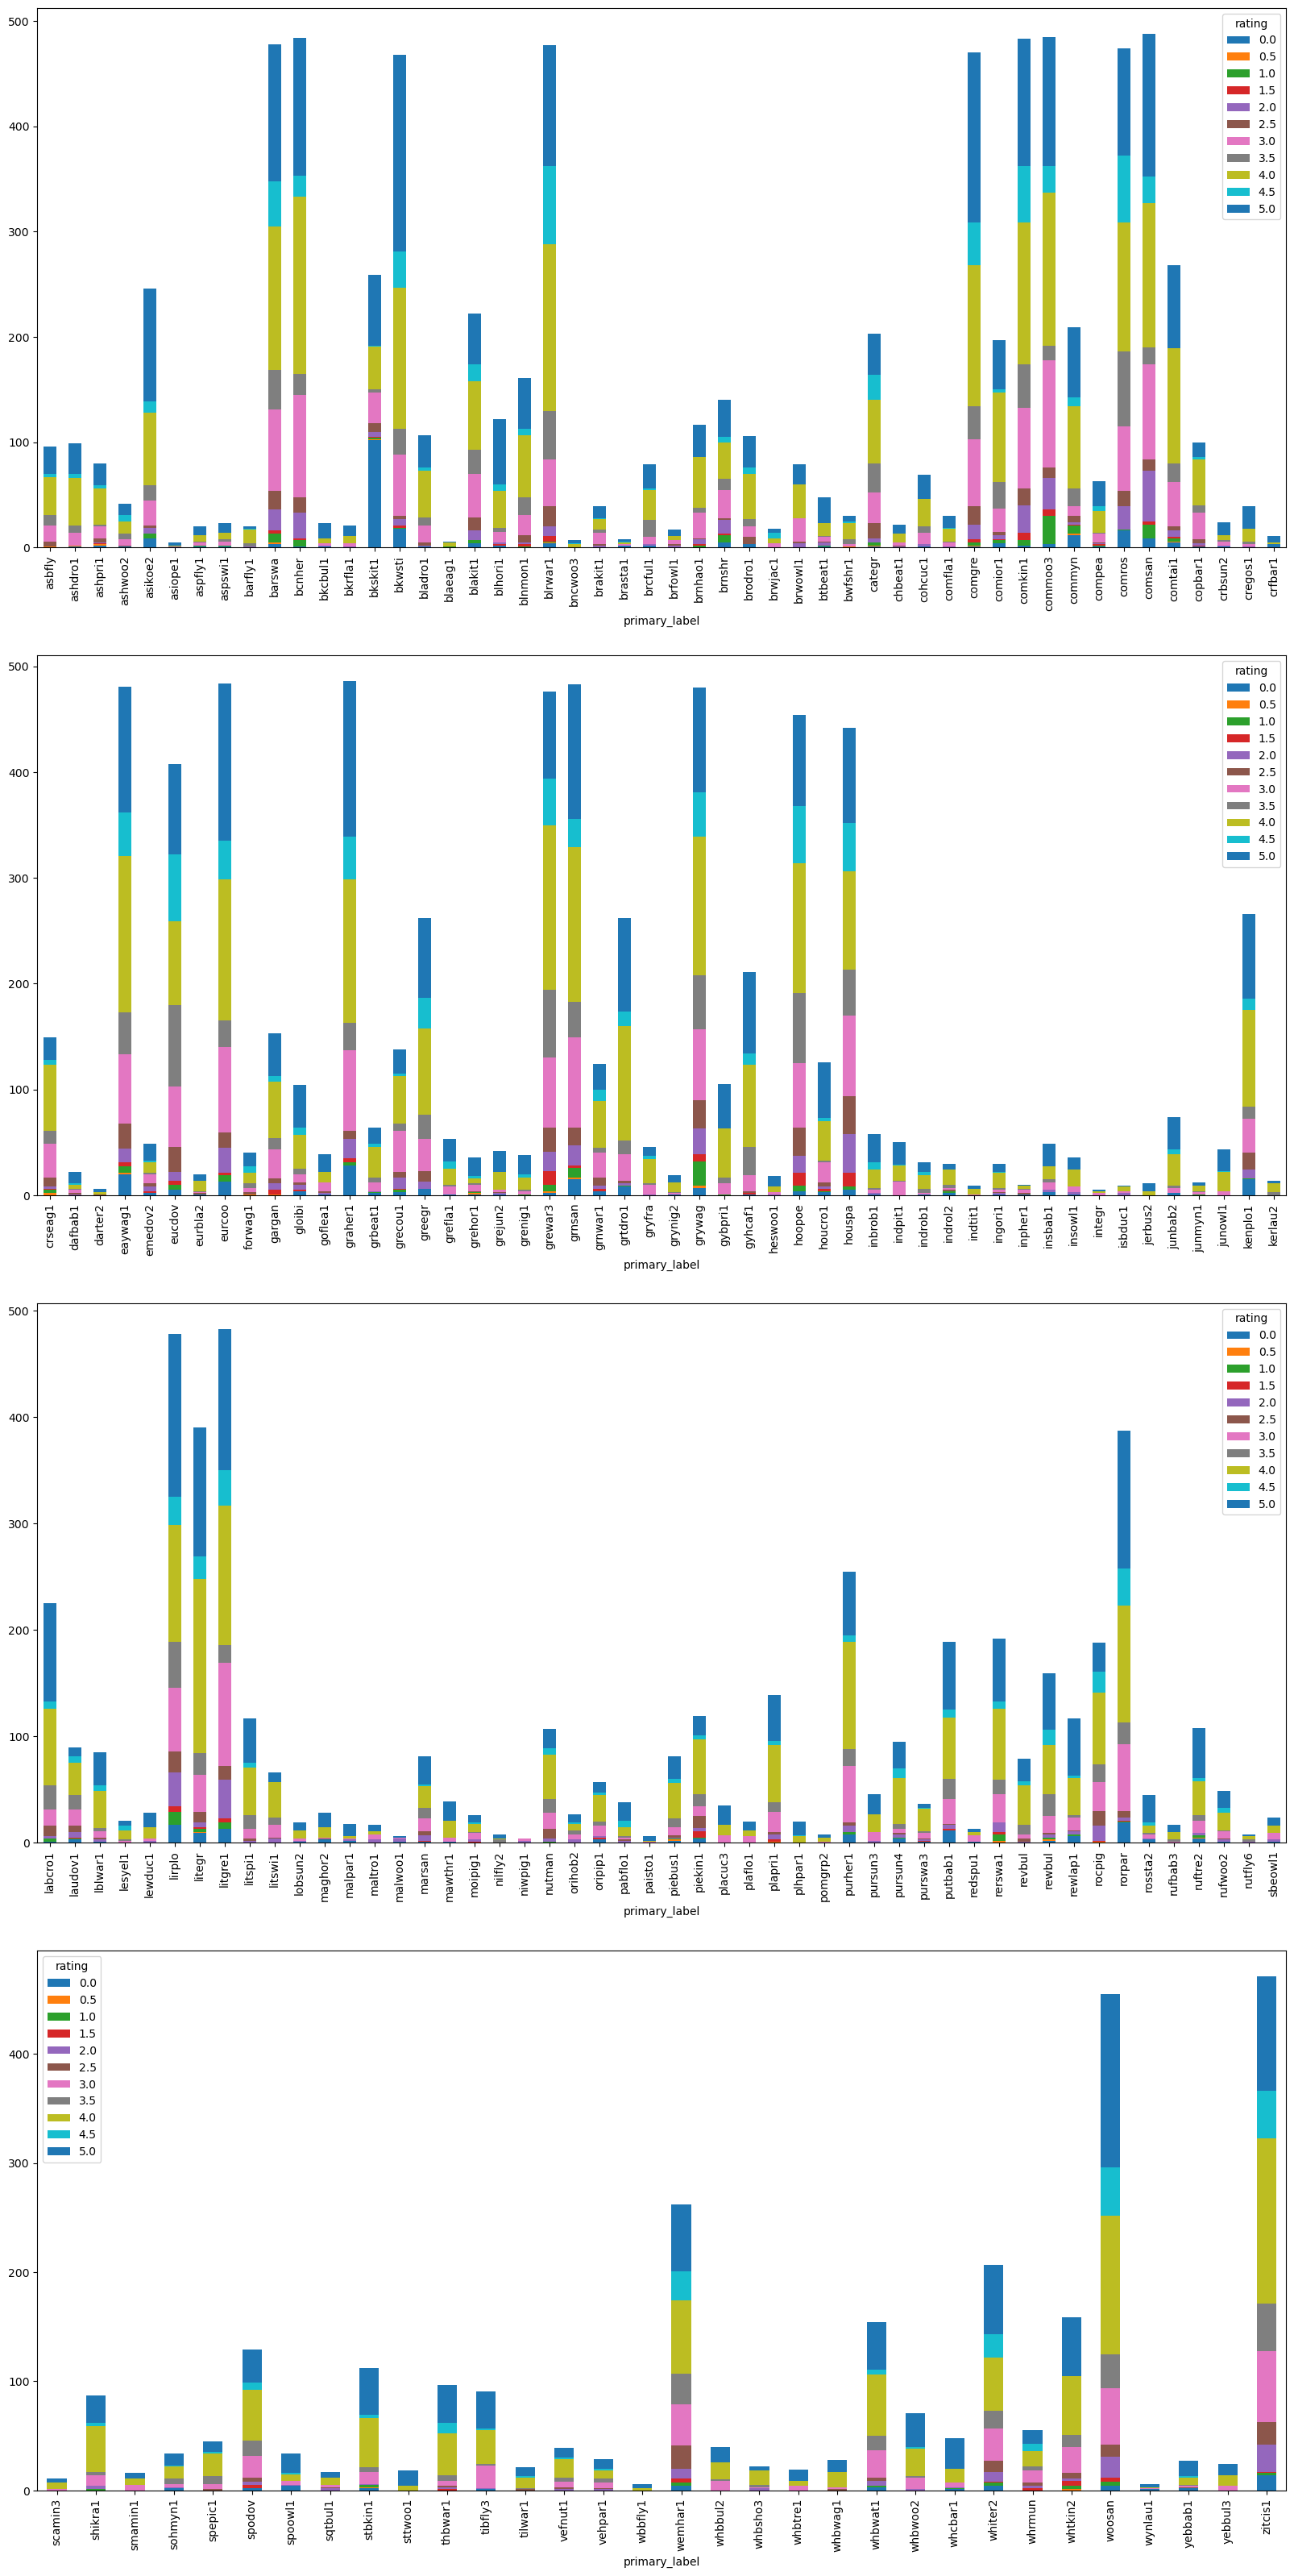

In [5]:
# group by primary label and make a bar plot of the asbfly rating value_counts
# train.groupby('primary_label')['rating'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(20,10))

# this is too cramped, split the birds into groups of 50, and make the same plot as a 4 row x 1 column subplot
fig, axs = plt.subplots(4, 1, figsize=(20,40))
for i in range(4):
    train.groupby('primary_label')['rating'].value_counts().unstack().iloc[i*50:(i+1)*50].plot(kind='bar', stacked=True, ax=axs[i])
    
plt.show()



<Axes: xlabel='primary_label'>

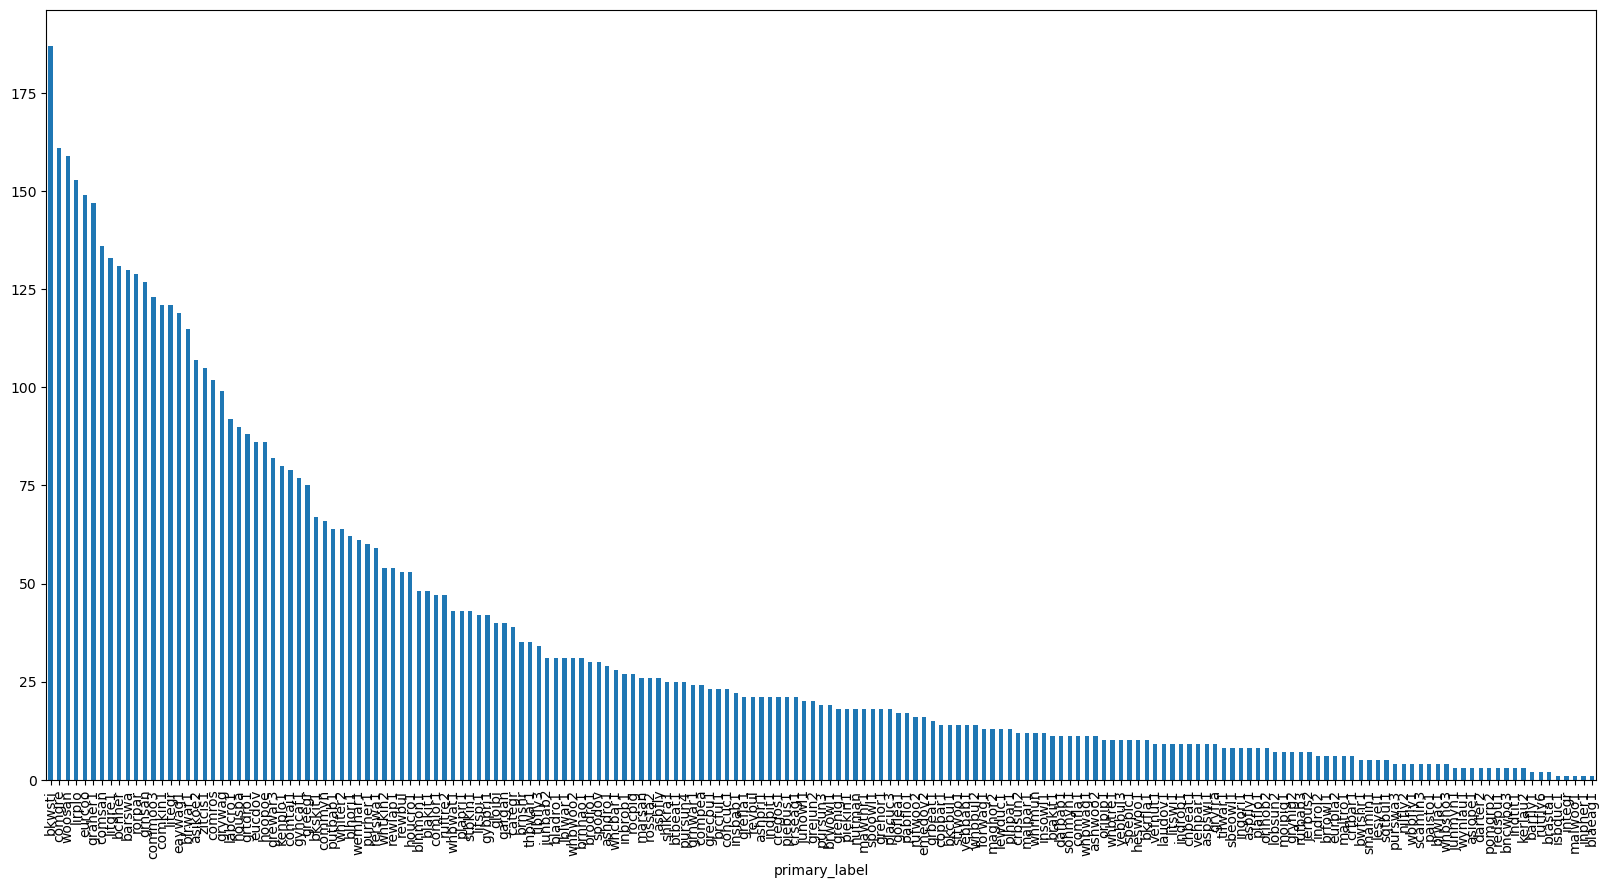

In [6]:
# count the number of rating = 5 for each primary label
train[train['rating'] == 5].groupby('primary_label').size().sort_values(ascending=False)

# plot as a bar chart
train[train['rating'] == 5].groupby('primary_label').size().sort_values(ascending=False).plot(kind='bar', figsize=(20,10))


In [7]:
# do all birds have at least one rating of 5?
train.groupby('primary_label')['rating'].max().value_counts()


rating
5.0    181
3.0      1
Name: count, dtype: int64

In [8]:
# keep only ratings 2, 3, 4, and 5
train = train[train['rating'] >= 2.0]
print(f'Train shape: {train.shape}')
# still 20053 rows, so only about 10% were lower than 3, and about 5% were lower than 2

Train shape: (21557, 7)


In [9]:
# what is the least 10 value counts of a primary label?
train['primary_label'].value_counts().tail(10)


primary_label
darter2    6
brasta1    6
wbbfly1    6
paisto1    6
asiope1    5
integr     5
wynlau1    5
blaeag1    5
malwoo1    5
niwpig1    4
Name: count, dtype: int64

In [10]:
# some primary labels have very few examples, maybe augment if not enough data.

In [11]:
# what is the number of unique primary labels?  Do I still have 182?
train['primary_label'].nunique()


182

In [12]:
# start with a small subset of the data, only the first primary label
train_asbfly = train[train['primary_label'] == 'asbfly']
print(f'Train asbfly shape: {train_asbfly.shape}')
train_asbfly.head()



Train asbfly shape: (95, 7)


primary_label      type  latitude  longitude             common_name  \
0        asbfly  ['call']   39.2297   118.1987  Asian Brown Flycatcher   
1        asbfly  ['song']   51.4030   104.6401  Asian Brown Flycatcher   
2        asbfly  ['song']   36.3319   127.3555  Asian Brown Flycatcher   
3        asbfly  ['call']   21.1697    70.6005  Asian Brown Flycatcher   
4        asbfly  ['call']   15.5442    73.7733  Asian Brown Flycatcher   

   rating             filename  
0     5.0  asbfly/XC134896.ogg  
1     2.5  asbfly/XC164848.ogg  
2     2.5  asbfly/XC175797.ogg  
3     4.0  asbfly/XC207738.ogg  
4     4.0  asbfly/XC209218.ogg

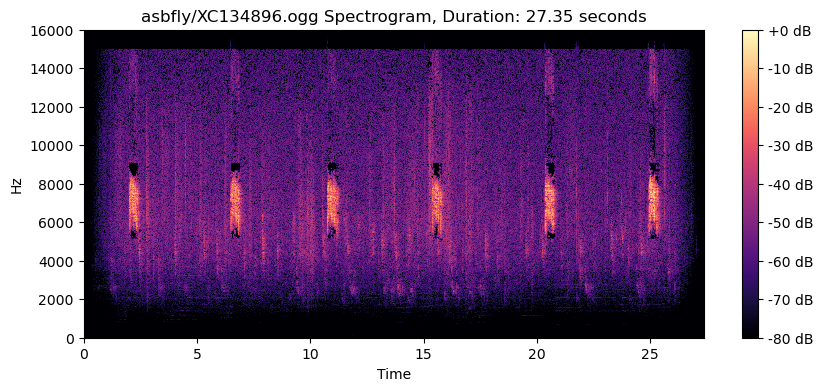

In [13]:
# open the first filename in the asbfly subset
filename = train_asbfly['filename'].iloc[0]

# load the audio file
y, sr = librosa.load(f'./train_audio/{filename}', sr=None)

# get the duration of the audio file
duration = librosa.get_duration(y=y, sr=sr)
    
# get the spectrogram of the audio file
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    
# plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{filename} Spectrogram, Duration: {duration:.2f} seconds')
plt.show()



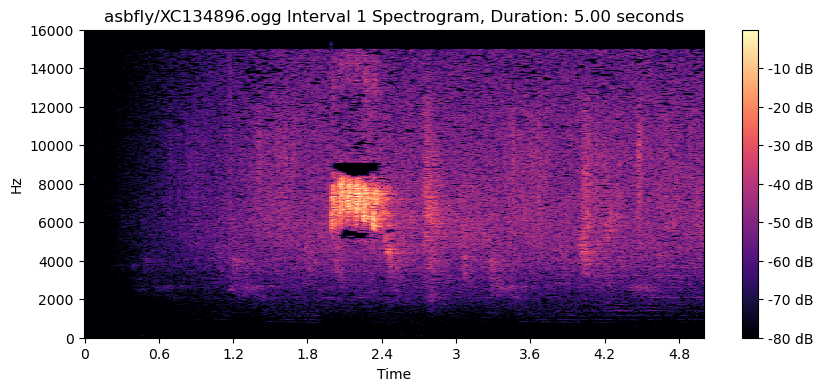

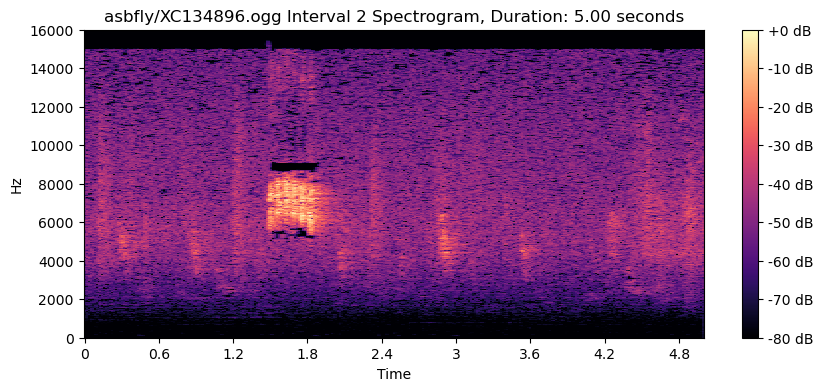

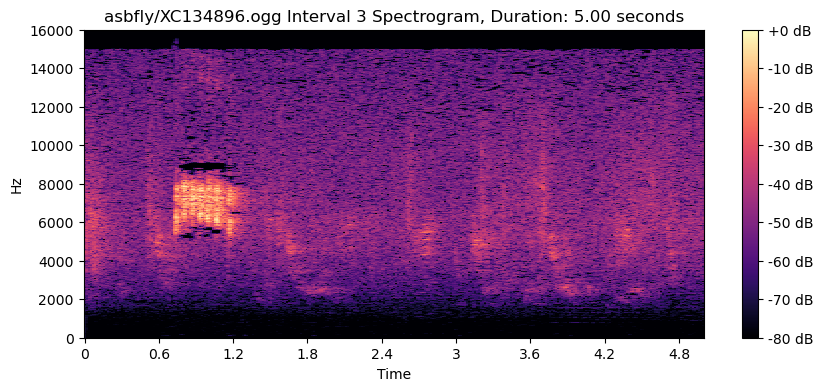

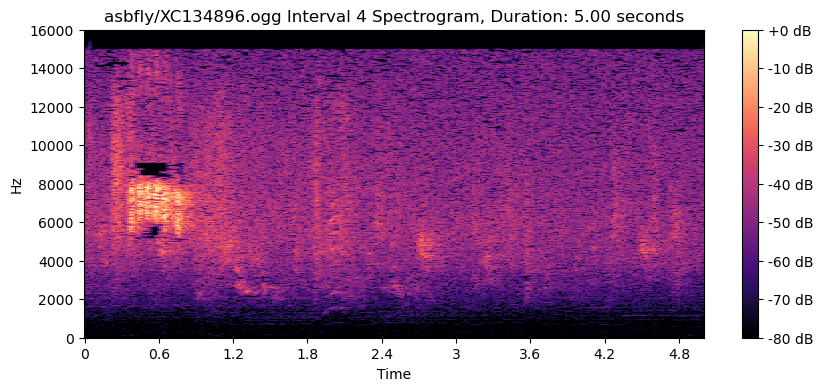

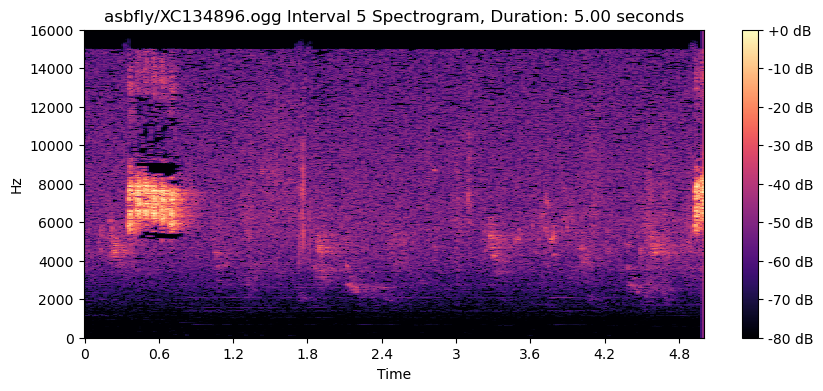

In [14]:
# break the audio file into 5 second intervals, remove the last interval if less than 5 sec, and get the spectrogram of each interval

# set the interval length
interval_length = 5

# get the number of intervals
num_intervals = int(np.floor(duration / interval_length))

# get the number of samples in each interval
samples_per_interval = int(interval_length * sr)

# loop through the intervals and take the spectrogram of each
for i in range(num_intervals):
    # get the start and end samples for the interval
    start_sample = i * samples_per_interval
    end_sample = (i + 1) * samples_per_interval
    # get the interval audio
    y_interval = y[start_sample:end_sample]
    # get the interval spectrogram
    D_interval = librosa.amplitude_to_db(np.abs(librosa.stft(y_interval)), ref=np.max)
    # plot the interval spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D_interval, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{filename} Interval {i+1} Spectrogram, Duration: {interval_length:.2f} seconds')
    plt.show()
    





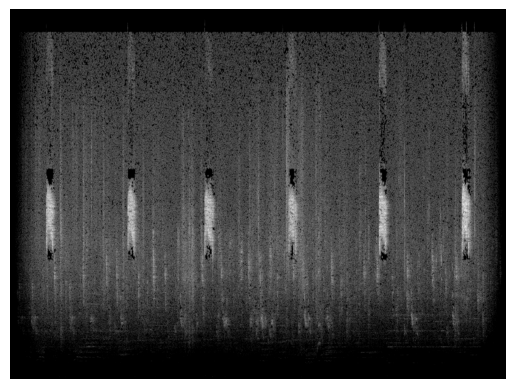

In [15]:
# plot only the spectrogram and not the colorbar, title, axis labels, etc.

plt.figure()#figsize=(6, 4))
plt.imshow(D, aspect='auto', origin='lower', cmap='gray')
plt.axis('off')
plt.show()



In [16]:
# what are the dimensions of the spectrogram?
D.shape


(1025, 1710)

### Now get rid of axis labels, colorbar, etc. and save the spectrograms as an images

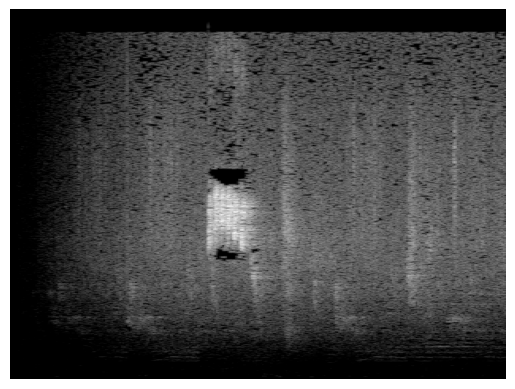

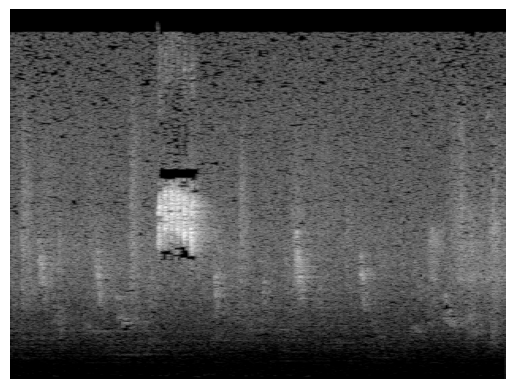

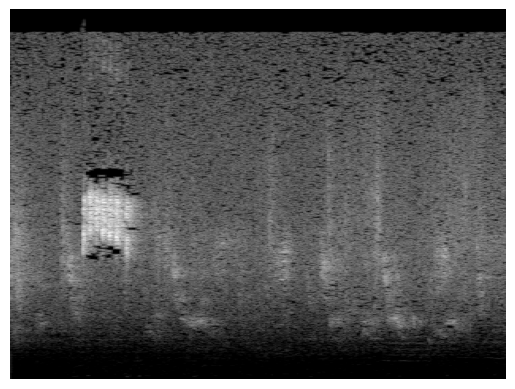

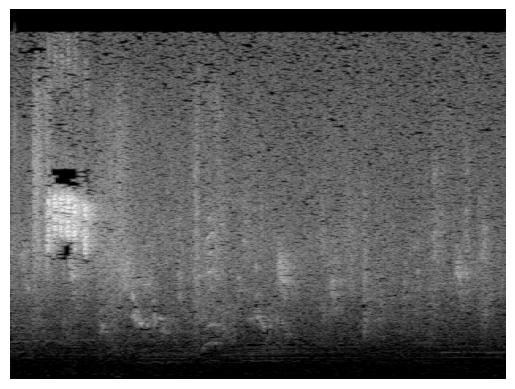

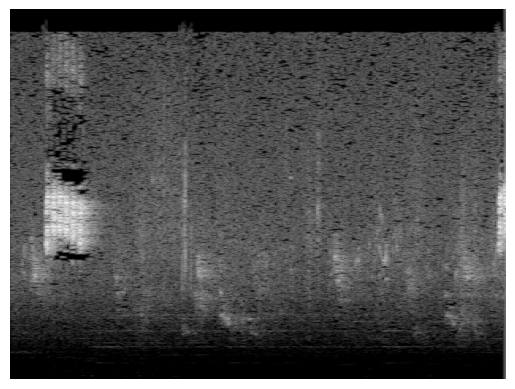

In [17]:
interval_length = 5
num_intervals = int(np.floor(duration / interval_length))
samples_per_interval = int(interval_length * sr)

# loop through the intervals and take the spectrogram of each
for i in range(num_intervals):
    # get the start and end samples for the interval
    start_sample = i * samples_per_interval
    end_sample = (i + 1) * samples_per_interval
    # get the interval audio
    y_interval = y[start_sample:end_sample]
    # get the interval spectrogram
    D_interval = librosa.amplitude_to_db(np.abs(librosa.stft(y_interval)), ref=np.max)
    # plot the interval spectrogram
    plt.figure()#figsize=(6, 4))
    plt.imshow(D_interval, aspect='auto', origin='lower', cmap='gray')
    plt.axis('off')
    plt.show()

In [18]:
# create a function that will take a filename, split it into 5 second intervals, and save the spectrograms as images
def save_spectrograms(filename, interval_length=5):
    # load the audio file
    y, sr = librosa.load(f'./train_audio/{filename}', sr=None)
    # get the duration of the audio file
    duration = librosa.get_duration(y=y, sr=sr)
    # get the number of intervals
    num_intervals = int(np.floor(duration / interval_length))
    # get the number of samples in each interval
    samples_per_interval = int(interval_length * sr)
    # loop through the intervals and take the spectrogram of each
    for i in range(num_intervals):
        # get the start and end samples for the interval
        start_sample = i * samples_per_interval
        end_sample = (i + 1) * samples_per_interval
        # get the interval audio
        y_interval = y[start_sample:end_sample]
        # get the interval spectrogram
        D_interval = librosa.amplitude_to_db(np.abs(librosa.stft(y_interval)), ref=np.max) # maybe want an absolute here
        # resize to 224x224 pixels
        D_interval = cv2.resize(D_interval, (224, 224))

        # plot the interval spectrogram
        # plt.figure()#figsize=(6, 4)
        # plt.imshow(D_interval, aspect='auto', origin='lower', cmap='gray')
        # plt.axis('off')
        #plt.show()
        # save the interval spectrogram as an image
        plt.imsave(f'./spectrograms/{filename[0:-4]}_interval_{i+1}.jpg', D_interval, cmap='gray')

# test the function on the first filename in the asbfly subset
save_spectrograms(train_asbfly['filename'].iloc[1])


In [19]:
# create a new subdirectory to save the spectrogram images

# check if the spectrograms folder exists, if not create it
if not os.path.exists('./spectrograms'):
    os.makedirs('./spectrograms', exist_ok=True)

# create subfolders under the spectrograms folder for each primary label
for primary_label in train['primary_label'].unique():
    # check if the primary label folder exists, if not create it
    if not os.path.exists(f'./spectrograms/{primary_label}'):
        os.makedirs(f'./spectrograms/{primary_label}', exist_ok=True)
    

In [20]:
# loop through the train_asbfly dataframe and save the spectrograms as images
for i in range(train_asbfly.shape[0]):
    filename = train_asbfly['filename'].iloc[i]
    save_spectrograms(filename)
    #print(f'{filename} spectrograms saved')


In [21]:
# looks like it is close to being ready to run on the full dataset, but want to check levels and standardize, then can get rid of empty intervals

## Check the Decibel Levels of the Audio Files
* Maybe best way would be to first load the raw audio files, then get the max and min for the whole file
* Then get the max and min and range for each 5 second interval and throw it out if below a certain threshold
* Then get the spectrogram of the remaining intervals


Filename: asbfly/XC164848.ogg, Duration: 15.80 sec, Samples: 505731, num_intervals: 3, samples_per_interval: 160000
Max: 0.0642133504152298, Min: -0.03785349056124687
Range: 0.10206684470176697

Interval 1 Max: 0.0642133504152298, Min: -0.03785349056124687
Range: 0.10206684470176697
Ratio: 1.0


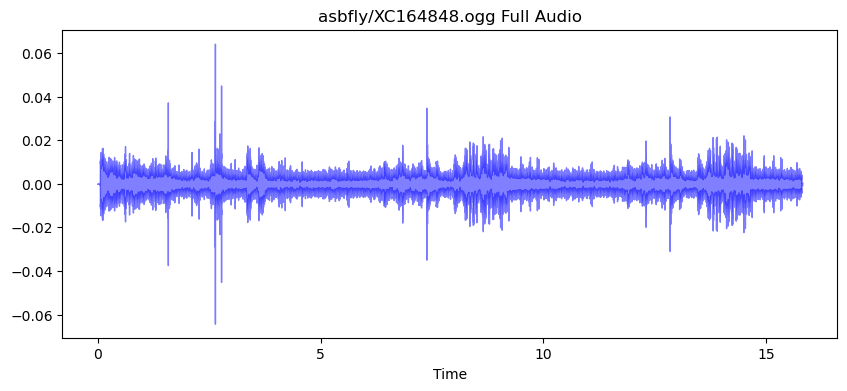

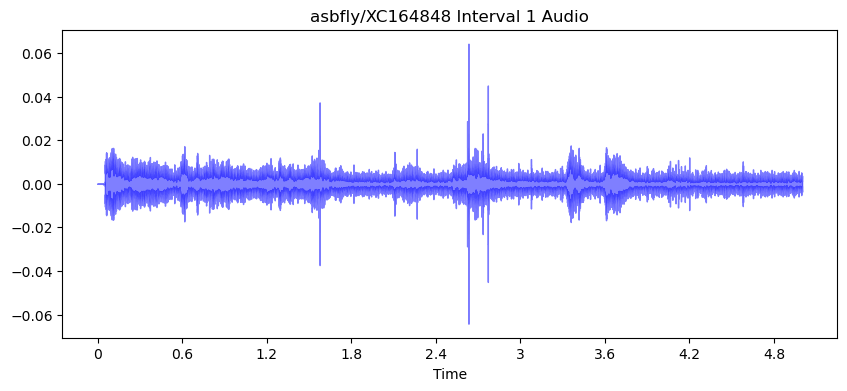

Interval 2 Max: 0.0337226539850235, Min: -0.03483908250927925
Range: 0.06856173276901245
Ratio: 0.6717336177825928


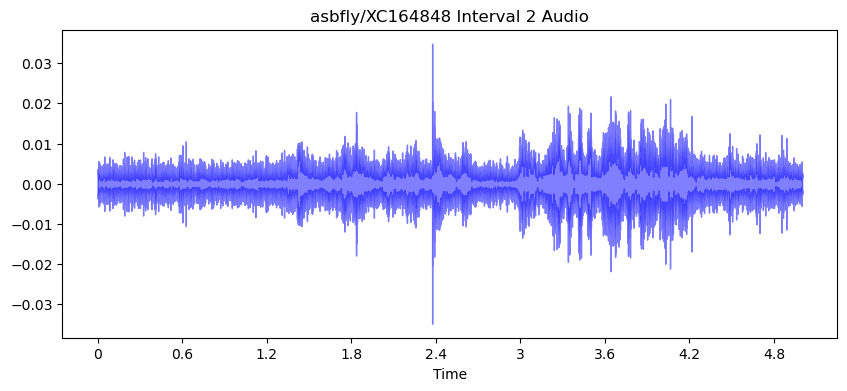

Interval 3 Max: 0.02981971763074398, Min: -0.030863862484693527
Range: 0.06068357825279236
Ratio: 0.5945473909378052


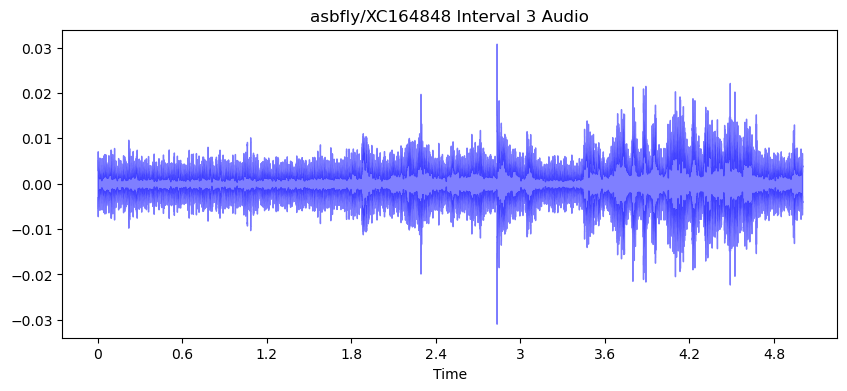

In [22]:
# load the first audio file in the asbfly subset, and look at the parameters
file_loc = 1
filename = train_asbfly['filename'].iloc[file_loc]

y, sr = librosa.load(f'./train_audio/{filename}', sr=None)

# get the duration of the audio file
duration = librosa.get_duration(y=y, sr=sr)

# get the number of intervals
interval_length = 5
num_intervals = int(np.floor(duration / interval_length))

# plot the whole audio file
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr,color="blue", alpha=0.5)
plt.title(f'{filename} Full Audio')

# get the max and min of the whole audio file
max_y = np.max(y)
min_y = np.min(y)
range_y = max_y - min_y
print(f'Filename: {filename}, Duration: {duration:.2f} sec, Samples: {len(y)}, num_intervals: {num_intervals}, samples_per_interval: {samples_per_interval}')
print(f'Max: {max_y}, Min: {min_y}')
print(f'Range: {range_y}\n')

# loop through the intervals and get the max and min of each
for i in range(num_intervals):
    # get the start and end samples for the interval
    start_sample = i * samples_per_interval
    end_sample = (i + 1) * samples_per_interval
    # get the interval audio
    y_interval = y[start_sample:end_sample]
    # get the max and min of the interval
    max_y_interval = np.max(y_interval)
    min_y_interval = np.min(y_interval)
    range_y_interval = max_y_interval - min_y_interval
    print(f'Interval {i+1} Max: {max_y_interval}, Min: {min_y_interval}')
    print(f'Range: {range_y_interval}')
    print(f'Ratio: {range_y_interval / range_y}')
    
    # plot the interval audio
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y_interval, sr=sr,color="blue",alpha=0.5)
    plt.title(f'{filename[0:-4]} Interval {i+1} Audio')
    plt.show()
    

maybe later create a smoothed version of the audio file by taking the rolling mean of the audio samples in numpy


In [23]:
# play the audio file 
filename = 
ipd.Audio(f'./train_audio/{filename}')


In [27]:
print(filename)

asbfly/XC464609.ogg


## Create function to save spectrograms
* same as before, but with a threshold for the minimum decibel level


In [24]:
# create a function that will take a filename, split it into 5 second intervals, and save the spectrograms as images, with a threshold for the minimum decibel level

def save_spectrograms(filename, interval_length=5, threshold_mult=.10,make_plots=False):

    removed_count = 0
    
    # load the audio file
    y, sr = librosa.load(f'./train_audio/{filename}', sr=None)
    
    # get the duration of the audio file
    duration = librosa.get_duration(y=y, sr=sr)
    
    # get the number of intervals
    num_intervals = int(np.floor(duration / interval_length))
    
    # get the number of samples in each interval
    samples_per_interval = int(interval_length * sr)
    
    # get the max and min of the whole audio file
    max_y = np.max(y)
    min_y = np.min(y)
    range_y = max_y - min_y
    
    # print the relevant parameters of the file
    #print(f'Filename: {filename}, duration: {duration:.2f} sec, num_intervals: {num_intervals}, samples_per_interval: {samples_per_interval}, Range: {range_y}')
    
    # loop through the intervals and take the spectrogram of each
    for i in range(num_intervals):
        
        # get the start and end samples for the interval
        start_sample = i * samples_per_interval
        end_sample = (i + 1) * samples_per_interval
        
        # get the interval audio
        y_interval = y[start_sample:end_sample]
        
        # get the max and min of the interval
        max_y_interval = np.max(y_interval)
        min_y_interval = np.min(y_interval)
        range_y_interval = max_y_interval - min_y_interval
        
        
        # if the range of the interval is less than the threshold, skip it
        if range_y_interval < threshold_mult * range_y:
            print(f'Filename: {filename}, duration: {duration:.2f} sec, Range: {range_y}, Range y interval: {range_y_interval}, ratio: {range_y_interval/range_y}')
            plt.figure(figsize=(12,3))
            librosa.display.waveshow(y, sr=sr,color="blue",alpha=0.5)
            librosa.display.waveshow(y_interval, sr=sr,color="red",alpha=0.5)
            removed_count += 1
            
            plt.show()
            continue
            
        # get the interval spectrogram
        D_interval = librosa.amplitude_to_db(np.abs(librosa.stft(y_interval)), ref=np.max) # maybe want an absolute here
        
        # resize to 224x224 pixels
        D_interval = cv2.resize(D_interval, (224, 224))

        # plot the interval spectrogram
        if make_plots:
            plt.figure()
            plt.imshow(D_interval, aspect='auto', origin='lower', cmap='gray')
            plt.axis('off')
            plt.show()
            
        if removed_count > 0: 
            print(f'Removed: {removed_count}')
        
        # save the interval spectrogram as an image
        plt.imsave(f'./spectrograms/{filename}_interval_{i+1}.jpg', D_interval, cmap='gray')
        
    return removed_count
        
    
# test the function on the first filename in the asbfly subset
#save_spectrograms(train_asbfly['filename'].iloc[1])


Filename: asbfly/XC376509.ogg, duration: 39.31 sec, Range: 0.8019541501998901, Range y interval: 0.11697140336036682, ratio: 0.14585797488689423


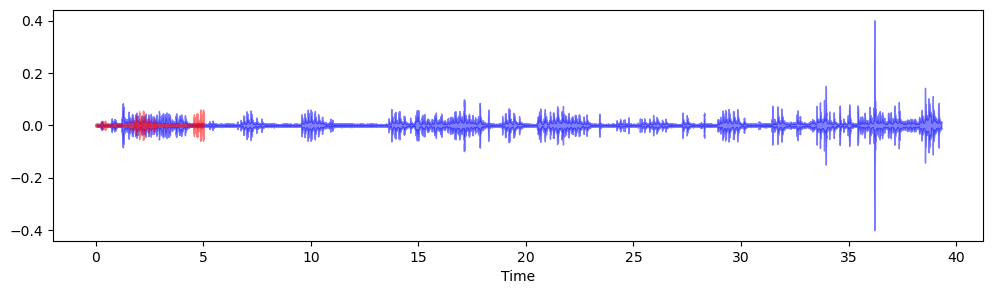

Filename: asbfly/XC376509.ogg, duration: 39.31 sec, Range: 0.8019541501998901, Range y interval: 0.11896577477455139, ratio: 0.14834485948085785


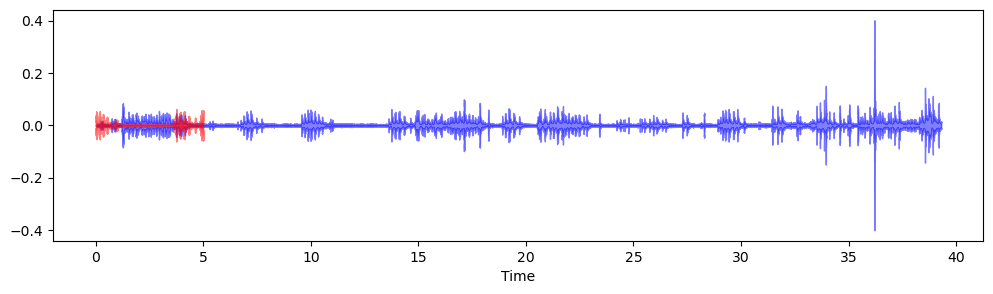

Removed: 2
Removed: 2
Removed: 2
Removed: 2
Filename: asbfly/XC396238.ogg, duration: 55.43 sec, Range: 0.5122710466384888, Range y interval: 0.07298271358013153, ratio: 0.14246894419193268


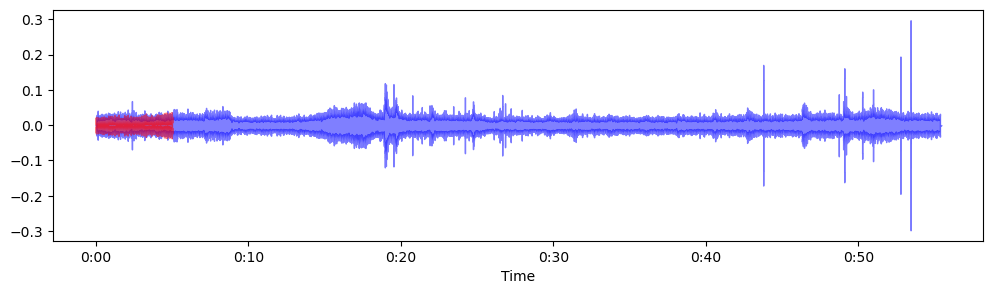

Removed: 1
Removed: 1
Removed: 1
Removed: 1
Filename: asbfly/XC396238.ogg, duration: 55.43 sec, Range: 0.5122710466384888, Range y interval: 0.06840008497238159, ratio: 0.13352322578430176


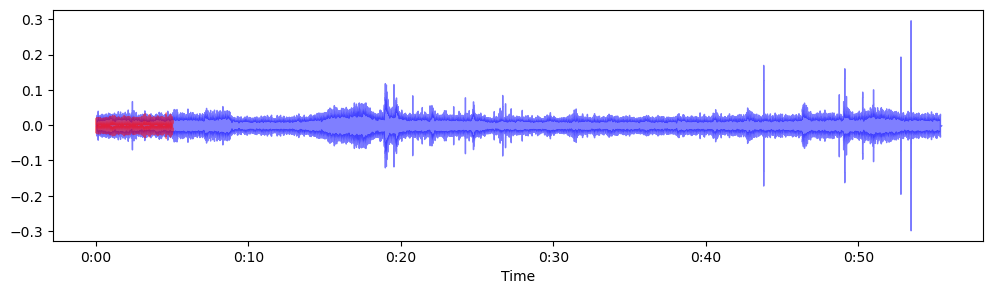

Removed: 2
Removed: 2
Removed: 2
Removed count: 4


In [25]:
# run the save_spectrograms function on the train_absfly dataset
rc = 0
for i in range(30): #train_asbfly.shape[0]):
    filename = train_asbfly['filename'].iloc[i]
    rc += save_spectrograms(filename,threshold_mult=.15, make_plots=False)
    #print(f'{filename} spectrograms saved')
print(f'Removed count: {rc}')


In [28]:
# play this audio file to hear the spike details
filename = 'asbfly/XC396238.ogg'
ipd.Audio(f'./train_audio/{filename}')

In [26]:
# orig method is flawed because there are occasional big sound spikes...these are clicks in the above file
# maybe some smoothing (rolling mean) first
# look into white noise removal
# and big spike removal


In [29]:
# what is the rating for the asbfly file 'asbfly/XC396238.ogg'?
train_asbfly[train_asbfly['filename'] == 'asbfly/XC396238.ogg']


primary_label      type  latitude  longitude             common_name  \
26        asbfly  ['call']    1.3415   103.7876  Asian Brown Flycatcher   

    rating             filename  
26     4.0  asbfly/XC396238.ogg

In [ ]:
# how is this a rating 4??? it sucks, mostly background noise and a dog barking